In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.optimize as optimize
import scipy.stats as stats

# Regression without knowing the underlying model

$$
y(i) = p^*(x(i)) + \epsilon(i),
$$
where $p^*$ is an unknown polynomial that we need to estimate.

In [2]:
t = 0.5
sigma = 0.2
def model(x):
    return t*x**3 + sigma*np.random.randn()

In [3]:
D = np.random.uniform(-2,2,25)
D = np.sort(D)
Y = [model(d) for d in D]

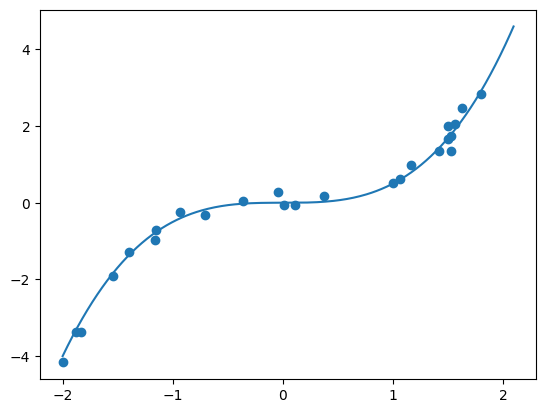

In [4]:
plt.scatter(D,Y)
D_plot=  np.arange(-2,2.1,0.015)
plt.plot(D_plot,t*D_plot**3)

## What goes wrong with our previous approach?

We can define a quadratic loss:
$$
J(p) = \frac{1}{m}\sum_{i=1}^m \left(y(i)-p(x(i)) \right)^2,
$$
and minimizes it among all polynomials.

In [5]:
z = np.polyfit(D, Y,len(D)-1)
p = np.poly1d(z)

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3505: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


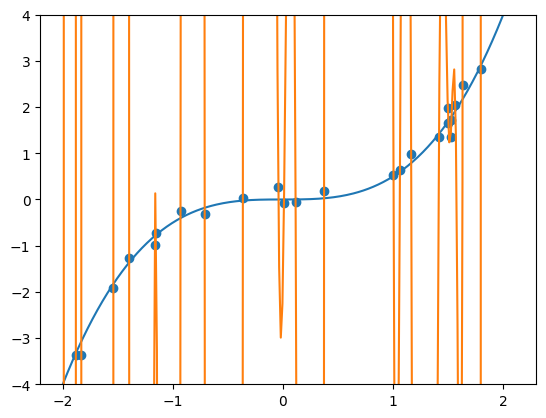

In [6]:
plt.scatter(D,Y)
plt.plot(D_plot,t*D_plot**3)
plt.ylim(-4,4)
plt.plot(D_plot,p(D_plot))

 Great, we achieve a loss of 0 but clearly our solution does not seem right!
 
 Let cheat a bit a see what happens if we are looking at a solution with the right degree:

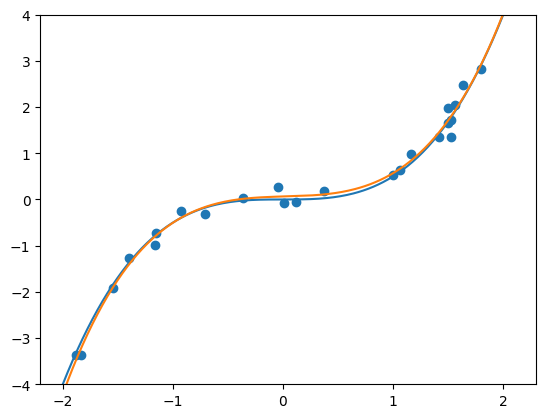

In [7]:
z = np.polyfit(D, Y,5)
p = np.poly1d(z)
plt.scatter(D,Y)
plt.plot(D_plot,t*D_plot**3)
plt.ylim(-4,4)
plt.plot(D_plot,p(D_plot))             

OK, this looks much better, but we cheated! Indeed, you can modify the degree for your polynomial fit and see that it is not easy to decide between degrees 3,4,5...

We can now formalize our problem as follows. Given the points $(x(i),y(i))$, we need to do two things:
 - decide on the degree of the polynomial $p^*$;
 - once the degree is fixed, estimate the parameters of the polynomial.
 
One natural way to deal with this new formulation of the problem is to check all possible degrees and make an estimation of the parameters for each possible choice. But then, we need to decide which degree to select. In order to do that, we will split the dataset in a training set and a validation set. We will use the training set to estimate the parameters of the polynomial for all possible degrees. To decide which degree we should select, we will compute the loss of the obtained polynomial on the validation set and pick the one with minimal validation loss.

Let see if this works?

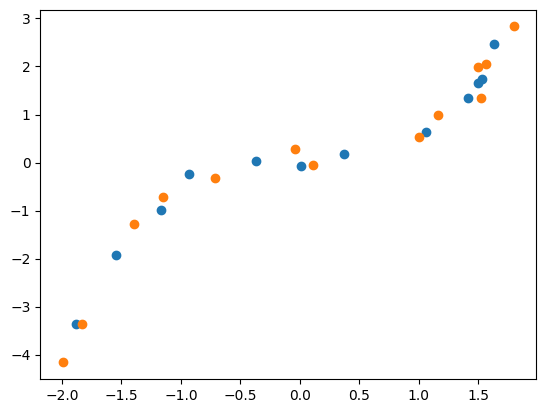

In [8]:
D_train = D[1::2]
Y_train = Y[1::2]
D_val = D[::2]
Y_val = Y[::2]
plt.scatter(D_train,Y_train)
plt.scatter(D_val, Y_val)

In [9]:
def get_error(deg):
    val_error = np.zeros(deg)
    train_error = np.zeros(deg)
    for i in range(deg):
        z = np.polyfit(D_train, Y_train, i)
        p = np.poly1d(z)
        train_error[i] = (np.mean((p(D_train)-Y_train)**2))
        val_error[i] = (np.mean((p(D_val)-Y_val)**2))
    return train_error, val_error

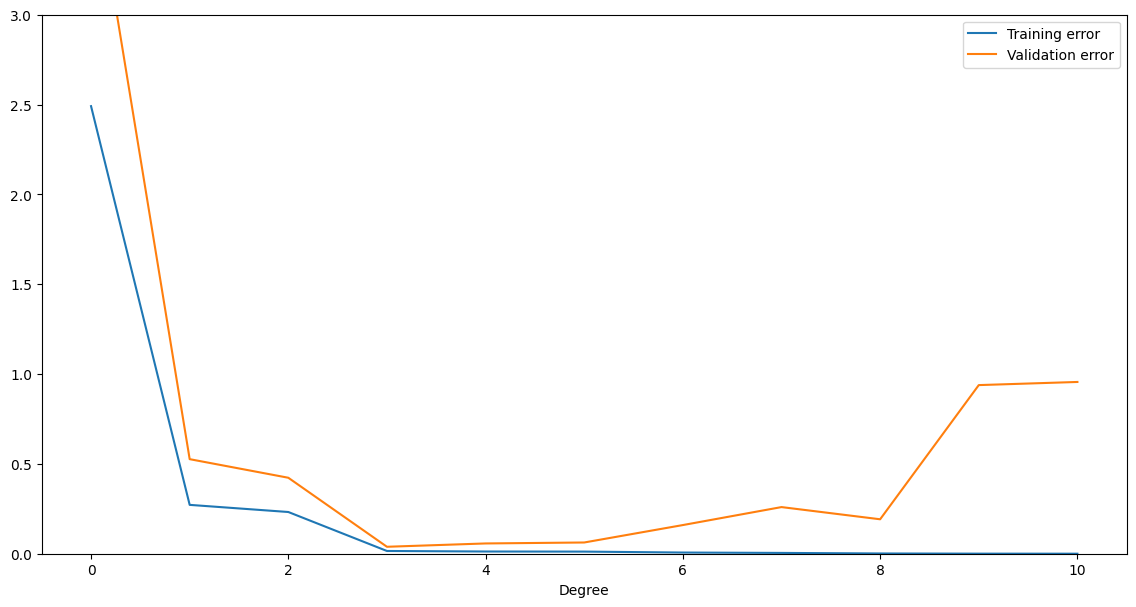

In [10]:
train_error, val_error = get_error(len(D_train)-1)
plt.figure(figsize=(14,7))
plt.plot(train_error, label='Training error')
plt.ylim(0, 3)
plt.plot(val_error, label='Validation error')
plt.xlabel("Degree")
plt.legend();

We see that the error on the training set is decreasing until it reaches 0 when the polynomial is able to inpterpolate all the points of the training set.

The error on the validation set is first decreasing as the training error but then starts to increase again. This is because the polynomial interpolating through the points of the training set is now missing a lot of points of the validation set, as shown below:

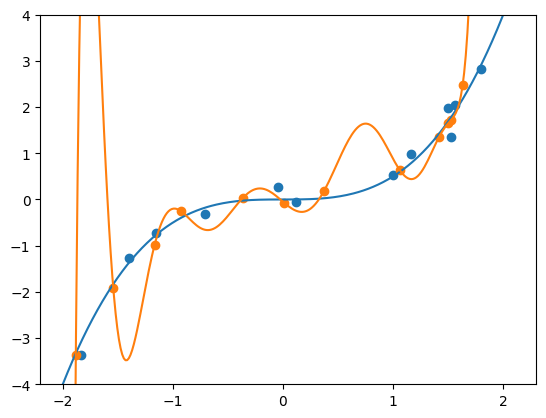

In [11]:
z = np.polyfit(D_train, Y_train, len(D_train)-1)
p = np.poly1d(z)
plt.scatter(D_val, Y_val)
plt.scatter(D_train,Y_train)
plt.plot(D_plot,t*D_plot**3)
plt.ylim(-4,4)
plt.plot(D_plot,p(D_plot)) 

To summarize:
 - for low degrees, our parametric model is not expressive enough to capture the true model resulting in a high error both on the training and validation set.
 - for high degrees, our model becomes very expressive and start to actually fit the noise in the dataset, resulting in a low error on the training set and a high error on the validation set.
 
To formalize a bit what happens, we need to introduce the notion of risk. For an estimator $f:\mathbb{R}\to\mathbb{R}$, we define the risk as:
$$
\mathcal{R}(f) = \mathbb{E}\left[(f(X)-Y)^2\right],
$$
where the average is taken over randomness of $(X,Y)$. In our case, we simulate the true model with $X\sim Unif[-2,2]$ and $Y = 0.5*X^3+\sigma \epsilon$, where $\epsilon\sim \mathcal{N}(0,1)$.

We also define $\mathcal{H}_k$ as the set of polynomial of maximum degree $k$. $\mathcal{H}_k$ is the hypothesis space. We denote by $H_\infty$ the set of all polynomials.

Our goal is to find:
$$
p^* = \arg\min_{p\in \mathcal{H}_\infty}\mathcal{R}(p).
$$

In our case, we can compute the risk:
\begin{eqnarray*}
\min_{p\in \mathcal{H}_\infty}\mathcal{R}(p) &=& \mathbb{E}\left[(Y-\mathbb{E}[Y|X])^2\right]\\
&=& \mathbb{E}\left[ (Y-0.5 X^3)^2\right]\\
&=& \sigma^2
\end{eqnarray*}

But in practice, we do not have access to the true underlying model defining the distribution of $(X,Y)$, hence we are not able to evaluate the average defining the risk.

Hence, we define the empirical risk:
$$
\hat{\mathcal{R}}(p) = \frac{1}{m}\sum_{i=1}^m \left(y(i)-p((x(i))\right)^2,
$$
which is an approximation of the true risk.
To be more precise, we defined two differetn empirical risks: for $\hat{\mathcal{R}}_{train}(p)$, the average is taken over the training set and for $\hat{\mathcal{R}}_{val}(p)$, the average is taken over the validation set.

Now we define the polynomial of degree at most $k$ minimizing the empirical risk on the training set:
$$
\hat{p}_k = \arg\min_{p\in \mathcal{H}_k}\hat{\mathcal{R}}_{train}(p).
$$

The training error above is given by $\hat{\mathcal{R}}_{train}(\hat{p}_k)$ and the validation error by $\hat{\mathcal{R}}_{val}(\hat{p}_k)$.

Since the data points in the validation set are not used for the polynomial fit, we have $\hat{\mathcal{R}}_{val}(\hat{p}_k)\approx \mathcal{R}(\hat{p}_k)$.

Unfortunately, what we would like to compute is
$$
p^*_k = \arg\min_{p\in \mathcal{H}_k}\mathcal{R}(p).
$$
Note that $\mathcal{R}(p^*_k) \downarrow \mathcal{R}(p^*)$ as $k\to \infty$.
Unfortunately, our experiment above shows us that $p^*_k\neq \hat{p}_k$, especially for large values of $k$.

In all cases, we can decompose the risk of our estimator in the following non-negative terms:
$$
\mathcal{R}(\hat{p}_k) = \underbrace{\mathcal{R}(\hat{p}_k)-\mathcal{R}(p^*_k)}_{(1)} + \underbrace{\mathcal{R}(p^*_k)-\mathcal{R}(p^*)}_{(2)}+\mathcal{R}(p^*).
$$

The first term is called the **estimation error**, the second term is called the **approximation error** and the last term $\mathcal{R}(p^*)$ is the true risk.

Clearly, as $k\to \infty$, the approximation error (2) vanishes as our model becomes more and more expressive. In our case, the approximation error is 0 for $k\geq 3$. But the estimation error (1) will unfortunately grows with $k$. Going back to our empirical findings above, we see that for low values of $k$, $\mathcal{R}(\hat{p}_k)$ is high because the approximation error (2) is high and the for high values of $k$, $\mathcal{R}(\hat{p}_k)$ is high because the estimation error (1) is high. In practice, we take the minimum of this curve as an estimate of $\mathcal{R}(p^*)$.

In [12]:
def get_risk(deg):
    risk = np.zeros(deg)
    for i in range(deg):
        z = np.polyfit(D_train, Y_train, i)
        p = np.poly1d(z)
        fun_int= lambda e,x : (p(x)-t*x**3 - sigma*e)**2*stats.norm.pdf(e)/4
        risk[i] = integrate.dblquad(fun_int,-2,2,lambda x: -10, lambda x: 10)[0]
    return risk

In [13]:
risk = get_risk(len(D_train)-1)

In [14]:
def opti_risk(x):
    if int(x) == 0:
        return t**2*2**6/7+sigma**2
    elif int(x) == 1:
        return t**2*2**6/7+sigma**2-t**2*2**6/5**2*3
    elif int(x) == 2:
        pass# left as an exercise!
    else:
        return sigma**2

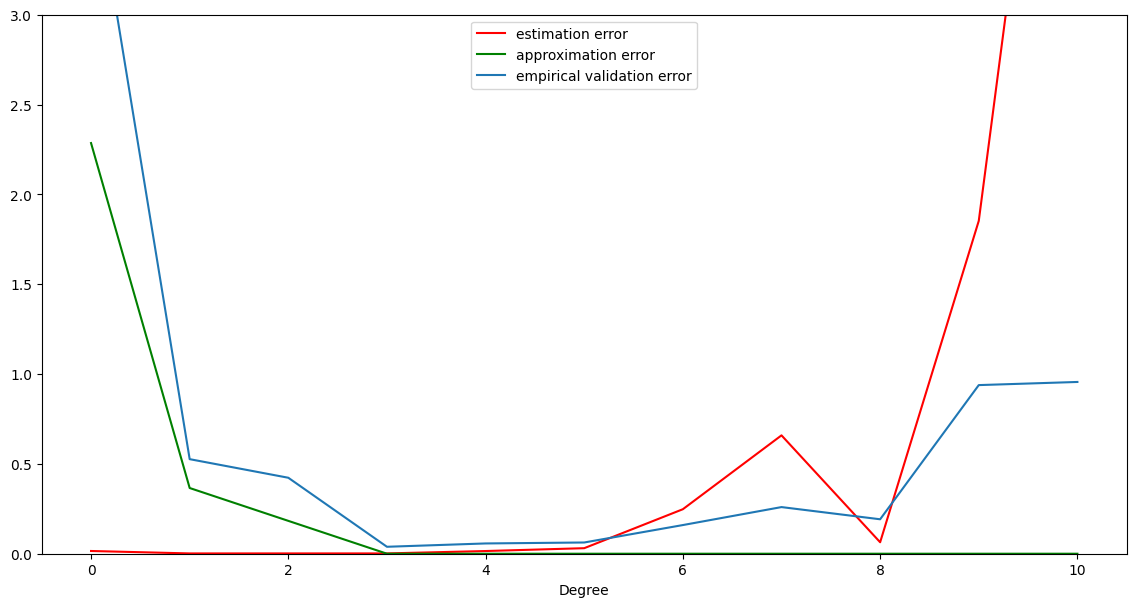

In [15]:
deg = [0,1,3,4,5,6,7,8,9,10]
plt.figure(figsize=(14,7))
plt.ylim(0, 3)
plt.plot(deg, [risk[int(d)]-opti_risk(d) for d in deg], color='red',label='estimation error')
plt.plot(deg, [opti_risk(d)-sigma**2 for d in deg],color='green',label='approximation error')
plt.plot(val_error, label='empirical validation error')
plt.xlabel("Degree")
plt.legend();

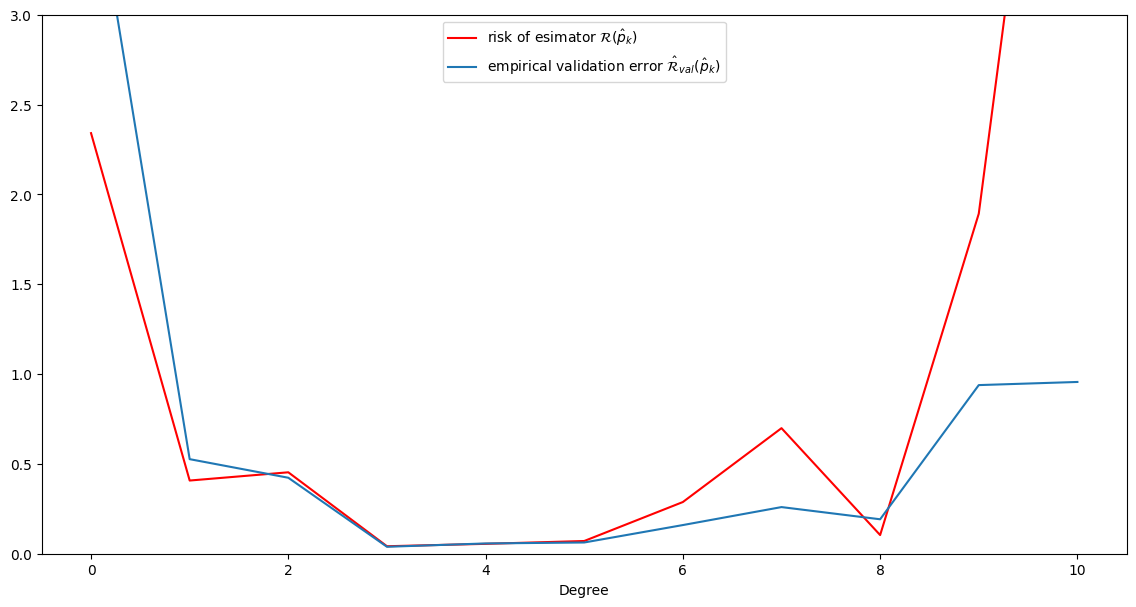

In [16]:
plt.figure(figsize=(14,7))
plt.ylim(0, 3)
plt.plot(risk, color='red',label='risk of esimator $\mathcal{R}(\hat{p}_k)$')
plt.plot(val_error, label='empirical validation error $\hat{\mathcal{R}}_{val}(\hat{p}_k)$')
plt.xlabel("Degree")
plt.legend();